# Model hiper optimization

all but tipo_exped=060 and 050

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [189]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.0.lw4.g2 - 18-5 total_condiciones_split lw4 - recall with zone groups"

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [190]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [191]:
# using only last year
split_date = "2018-05-01"
df = df[df["FECHA_SINI"] >= split_date].copy()

In [192]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-05-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [193]:
df = df[(df["total_condicion"] < 4)]
df_val = df_val[(df_val["total_condicion"] < 4)]

In [194]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
g1 = [6, 5]
df = df[~(df["TIPO_EXPED"].isin(g1))]
df_val = df_val[~(df_val["TIPO_EXPED"].isin(g1))]

In [195]:
pd.crosstab(df["TIPO_EXPED"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
TIPO_EXPED,,
0,1727,6
1,26979,74
2,158513,31
3,132307,38
4,4390,16


In [196]:
df["TIPO_EXPED"].value_counts()

2    158544
3    132345
1     27053
4      4406
0      1733
Name: TIPO_EXPED, dtype: int64

In [197]:
# delete unique value columns (for tipo_exped == 060)
use_cols = df.nunique()[df.nunique() > 1].index
df = df[use_cols]
df_val = df_val[use_cols]

In [198]:
cond_cols = df.filter(regex="^cond_*").columns
cond_cols

Index(['cond_04', 'cond_05', 'cond_06', 'cond_09', 'cond_11', 'cond_C1',
       'cond_C13', 'cond_C14', 'cond_C15', 'cond_C16', 'cond_C17', 'cond_C21',
       'cond_C6', 'cond_C7', 'cond_C8', 'cond_C9'],
      dtype='object')

In [199]:
# create column number of conditions activated
df["cant_cond"] = (df[cond_cols] > 0).sum(axis=1)
df_val["cant_cond"] = (df_val[cond_cols] > 0).sum(axis=1)

In [200]:
df["cant_cond"].value_counts()

0    295365
1     27463
2      1214
3        39
Name: cant_cond, dtype: int64

In [201]:
df["EXISTE_FRAUDE"].value_counts()

False    323916
True        165
Name: EXISTE_FRAUDE, dtype: int64

In [202]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-05-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [203]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [204]:
pd.crosstab(df["FECHA_SINI"].dt.month, [df["EXISTE_FRAUDE"], df["TIPO_EXPED"]], margins=True)

EXISTE_FRAUDE False                              True                     All
TIPO_EXPED        0      1       2       3     4    0   1   2   3   4        
FECHA_SINI                                                                   
1               131   2310   14032   14743   492    0   1   0   2   2   31713
5               200   3372   18843   14489   424    1  19   3   5   3   37359
6               199   3273   18405   13383   468    1   6   9   3   2   35749
7               176   2919   18272   14154   491    0  17   5   4   3   36041
8               172   3244   18890   14818   458    1   9   2   4   1   37599
9               218   2941   16992   14622   498    1  11   5   4   1   35293
10              206   3221   18225   16072   489    1   5   2   5   1   38227
11              195   2904   16956   14431   485    0   3   2   5   0   34981
12              230   2795   17898   15595   585    1   3   3   6   3   37119
All            1727  26979  158513  132307  4390    6  74  31  38  16  324081

In [205]:
# using only last year
split_date = "2018-12-01"
df_train = df[df["FECHA_SINI"] < split_date].copy()
df_opt = df[df["FECHA_SINI"] >= split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-05-01 00:00:00 2018-11-30 00:00:00
2018-12-01 00:00:00 2019-01-31 00:00:00


In [206]:
df_train["EXISTE_FRAUDE"].value_counts(normalize=True), df_opt["EXISTE_FRAUDE"].value_counts(normalize=True)

(False    0.999436
 True     0.000564
 Name: EXISTE_FRAUDE, dtype: float64, False    0.999695
 True     0.000305
 Name: EXISTE_FRAUDE, dtype: float64)

In [207]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.7876086533922075, 0.2123913466077925)

In [208]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [209]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"] # , "es_gte_5"

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [210]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [211]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [212]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

255249, 68832
255249, 68832


In [213]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.000564155001586686, 0.00030509065550906553)

In [214]:
y_train.value_counts(dropna=False)

False    255105
True        144
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [215]:
from sklearn.utils.class_weight import compute_class_weight

In [216]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights, weights[1] / weights[0]

(array([5.00254696e-01, 9.82063636e+02]), 1963.127272727273)

In [217]:
# configs
list_weights = [350] # , 350
[{0:1, 1:l} for l in list_weights]

[{0: 1, 1: 350}]

### VERSION SIMPLE

In [219]:
rf_params = {
    "n_estimators": [40],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt'],  # , None
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
# param_configs.append(rf_params)
# param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': [60, 100], 
#    "min_samples_leaf": [3, 5, 7],
#    "max_depth": [10, 40], # 10,
#    'min_samples_split': [5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bynode": [0.5 , 1],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': [60, 100], 
#    'num_leaves': [10, 20, 50],
#    'max_depth': [5, 10, 30],
#    'min_child_samples': [3, 5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bytree": [0.5 , 1],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}

param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'scale_pos_weight': [350]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'class_weight': [{0: 1, 1: 350}]}]

### VERSION COMPLEJA

In [85]:
n_estimators = [60]

rf_params = {
    "n_estimators": n_estimators,
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
# param_configs.append(rf_params)
# param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': n_estimators, 
    "max_depth": [15, 40, 5],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': n_estimators, 
#    'num_leaves': [10, 20, 50],
    "max_depth": [15, 40],
    'min_child_samples': [3, 5, 7, 11],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60],
  'max_depth': [15, 40, 5],
  'learning_rate': [1.0, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'scale_pos_weight': [345]},
 {'n_estimators': [60],
  'max_depth': [15, 40],
  'min_child_samples': [3, 5, 7, 11],
  'learning_rate': [1.0, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'class_weight': [{0: 1, 1: 345}]}]

### Optimizing

In [220]:
# using without grid with list of models
rfs = []
# rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(DecisionTreeClassifier(random_state=random_state))
rfs.append(XGBClassifier(random_state=random_state, n_jobs=-1))
rfs.append(LGBMClassifier(random_state=random_state, silent=False, n_jobs=-1))
rfs

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=-1, nthread=None, objective='binary:logistic',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=True, subsample=1),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]

In [221]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "recall"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=param_configs[counter], seed=random_state, num_threads=1)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Comparing 6 parameter setting(s) using 1 CPU thread(s) ( 6 job(s) per thread ).
Best score: 0.047619047619047616
Best config: {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 350}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective

In [227]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
GridSearch(cv_folds=3,
           model=XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.01, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=350,
                               seed=0, silent=True, subsample=1),
           num_threads=1,
           param_grid={'learning_rate': [1.0, 0.1, 0.01],
                       'n_estimators': [60, 100], 'scale_pos_weight': [350]},
           seed=42) 0.047619047619047616
GridSearch(cv_folds=3,
           model=LGBMClassifier(boosting_type='gbdt',
                                class_weight={0: 1, 1: 350},
                                col

In [228]:
# select best grid
best_model = best_models_[np.argmax(best_scores_)]

# select by hand
# best_model = best_models_[0]

In [229]:
sorted_ids = np.argsort(best_model.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (best_model.scores[i], best_model.params[i]))

Grid scores:
0.048 for {'learning_rate': 0.01, 'n_estimators': 60, 'scale_pos_weight': 350}
0.048 for {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 350}
0.000 for {'learning_rate': 1.0, 'n_estimators': 60, 'scale_pos_weight': 350}
0.000 for {'learning_rate': 1.0, 'n_estimators': 100, 'scale_pos_weight': 350}
0.000 for {'learning_rate': 0.1, 'n_estimators': 60, 'scale_pos_weight': 350}
0.000 for {'learning_rate': 0.1, 'n_estimators': 100, 'scale_pos_weight': 350}


In [231]:
y_opt_pred = best_model.predict(X_opt)
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.020618556701030927, 0.5232645528019815)

In [232]:
confusion_matrix(y_opt, y_opt_pred)

array([[68736,    75],
       [   20,     1]])

best:<br>

In [233]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                349    12     1     0
1               5062    43     4     0
2              31924     6     3     0
3              30338     0     8     0
4               1063    14     4     1

**Tronador**

In [66]:
confusion_matrix(y_opt, X_opt["total_condicion"] >= 5)

array([[68811,     0],
       [   21,     0]])

In [67]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], X_opt["total_condicion"] >= 5])

EXISTE_FRAUDE,False,True
total_condicion,False,False
TIPO_EXPED,,
0,361,1
1,5105,4
2,31930,3
3,30338,8
4,1077,5


## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

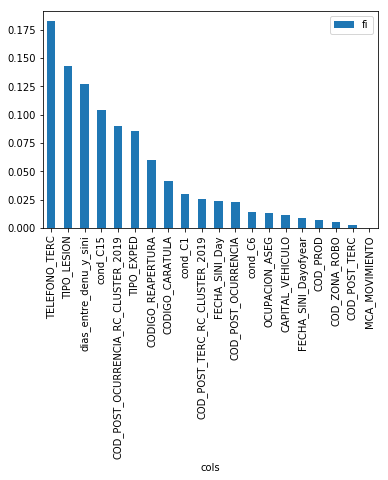

In [234]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [237]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 18 of 119


In [238]:
"""to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep"""

'to_remove = [\'COD_POST_POLIZA_RT_CLUSTER_2019\', \'COD_POST_OCURRENCIA_RT_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_RC_CLUSTER_2019\',  \'COD_POST_POLIZA_RC_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_DP_CLUSTER_2019\', \'COD_POST_POLIZA_DP_CLUSTER_2019\',\n             "COD_CAUSA_SINI", \n            ] # "es_gte_5", "total_condicion", \n\nfor col in to_remove:\n    if(col in to_keep):\n        to_keep.remove(col)\nto_keep'

In [239]:
# best model
best_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=350,
              seed=0, silent=True, subsample=1)

### Training again with less features

In [240]:
X_train_red = X_train[to_keep].copy()
print(len(X_train_red.columns))

18


In [241]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(best_model.best_estimator_)
rf.fit(X_train_red, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=350,
              seed=0, silent=True, subsample=1)

In [242]:
y_opt_pred = rf.predict(X_opt[to_keep])
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.020618556701030927, 0.5232645528019815)

In [243]:
confusion_matrix(y_opt, y_opt_pred)

array([[68736,    75],
       [   20,     1]])

...

In [102]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                361     0     1     0
1               5105     0     4     0
2              31930     0     3     0
3              30338     0     8     0
4               1074     3     4     1

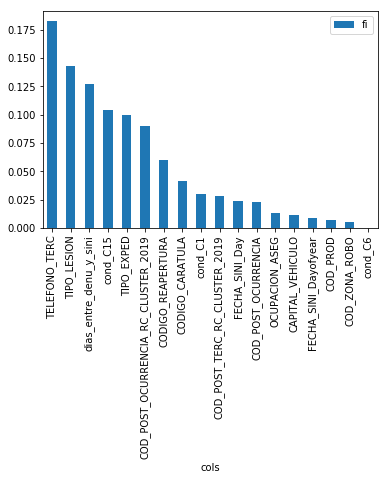

In [244]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# model with validation set

## full features final model

In [77]:
rf_full = copy(best_model)
rf_full.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [78]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.468, 0.905


In [79]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4475,  388],
       [  69,  201]])

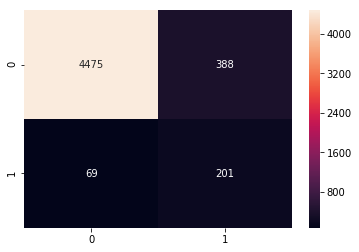

In [80]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [245]:
rf_full = copy(best_model.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=350,
              seed=0, silent=True, subsample=1)

In [246]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.000, 0.872


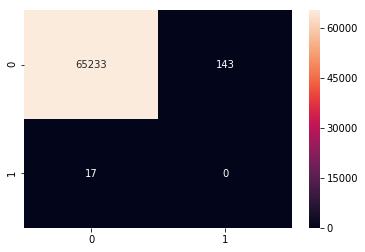

In [247]:
conf_mat = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [248]:
pd.crosstab(X_val["TIPO_EXPED"], [y_val, y_val_pred])

EXISTE_FRAUDE  False       True 
col_1          False True  False
TIPO_EXPED                      
0                379     0     2
1               5187     0     7
2              30794     0     3
3              28078     7     4
4                795   136     1

In [161]:
# run this to save the reduce model
best_model = copy(rf_full)

## Tronador (sum cond >=5) comparison

In [63]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.0,0.5)


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


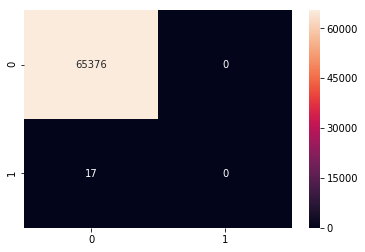

In [64]:
conf_mat = confusion_matrix(y_val, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Model % sec != 0.5

0.007, 0.816


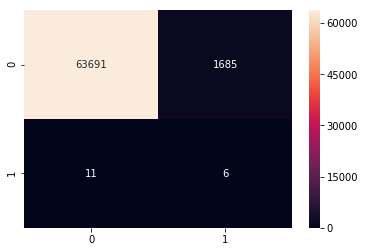

In [114]:
porc_sec = 0.05
y_val_pred = y_val_pred_prob >= porc_sec
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)
conf_mat = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [79]:
pd.crosstab(X_val["TIPO_EXPED"], [y_val, y_val_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                378     1     2     0
1               5178     9     7     0
2              30794     0     3     0
3              28085     0     4     0
4                813   118     0     1

# Saving final model & columns used into hard drive

In [162]:
path_to_save = f"models/{model_id}/"
os.makedirs(path_to_save, exist_ok=True)

In [163]:
model_file = os.path.join(path_to_save, f"{model_id}.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

In [164]:
# save file for humans
model_file = os.path.join(path_to_save, f"{model_id} - readable.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, 0) # 0 is human readable format

In [165]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['COD_PROD', 'CODIGO_VEHICULO', 'FECHA_SINI_Day', 'TELEFONO_TERC', 'dias_entre_denu_y_sini', 'FECHA_SINI_Dayofyear', 'OCUPACION_ASEG', 'COD_POST_OCURRENCIA', 'COD_CAUSA_SINI', 'COD_POST_POLIZA', 'CAPITAL_VEHICULO', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'ANTIG_pol', 'CANT_RENOVACION', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'CAPITAL_ASEGURADO_COTIZACION', 'dist_fformal_fdenu', 'FECHA_SINI_Elapsed', 'CONV_COMISIONARIO', 'COD_POST_TERC_DP_CLUSTER_2019', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'COD_ZONA_ROBO', 'CODIGO_REAPERTURA', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_COBRO_ANTERIOR', 'TIPO_ACTIVIDAD', 'TIPO_SINIESTRO', 'FECHA_SINI_Dayofweek', 'COD_POST_TERC', 'FALTANTE', 'TIPO_LESION', 'ESTADO_CIVIL', 'CODIGO_CARATULA', 'dist_fformal_fsini', 'FECHA_SINI_Week', 'cond_C15', 'CAPITAL_ACCESORIOS', 'cond_C7']


In [166]:
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - n_features_{len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [120]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [167]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [179]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df_test = df_test[(df_test["total_condicion"] < 4)]
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
g1 = [6, 5]
df_test = df_test[~(df_test["TIPO_EXPED"].isin(g1))]

In [169]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [170]:
m = load_model(model_file)
columns = load_columns(columns_file)

In [171]:
print(columns)

['COD_PROD', 'CODIGO_VEHICULO', 'FECHA_SINI_Day', 'TELEFONO_TERC', 'dias_entre_denu_y_sini', 'FECHA_SINI_Dayofyear', 'OCUPACION_ASEG', 'COD_POST_OCURRENCIA', 'COD_CAUSA_SINI', 'COD_POST_POLIZA', 'CAPITAL_VEHICULO', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'ANTIG_pol', 'CANT_RENOVACION', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'CAPITAL_ASEGURADO_COTIZACION', 'dist_fformal_fdenu', 'FECHA_SINI_Elapsed', 'CONV_COMISIONARIO', 'COD_POST_TERC_DP_CLUSTER_2019', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'COD_ZONA_ROBO', 'CODIGO_REAPERTURA', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_COBRO_ANTERIOR', 'TIPO_ACTIVIDAD', 'TIPO_SINIESTRO', 'FECHA_SINI_Dayofweek', 'COD_POST_TERC', 'FALTANTE', 'TIPO_LESION', 'ESTADO_CIVIL', 'CODIGO_CARATULA', 'dist_fformal_fsini', 'FECHA_SINI_Week', 'cond_C15', 'CAPITAL_ACCESORIOS', 'cond_C7']


In [180]:
# create cant_cond column
cond_cols = df.filter(regex="^cond_").columns
df_test["cant_cond"] = (df_test[cond_cols] > 0).sum(axis=1)
df_test["cant_cond"].value_counts(dropna=False)

0    26265
1     5058
2      334
3       17
Name: cant_cond, dtype: int64

In [181]:
X_test = df_test[columns]
y_test = df_test["EXISTE_FRAUDE"]

In [182]:
X_test.head()

,COD_PROD,CODIGO_VEHICULO,FECHA_SINI_Day,TELEFONO_TERC,dias_entre_denu_y_sini,FECHA_SINI_Dayofyear,OCUPACION_ASEG,COD_POST_OCURRENCIA,COD_CAUSA_SINI,COD_POST_POLIZA,CAPITAL_VEHICULO,COD_POST_OCURRENCIA_RC_CLUSTER_2019,ANTIG_pol,CANT_RENOVACION,COD_POST_OCURRENCIA_DP_CLUSTER_2019,CAPITAL_ASEGURADO_COTIZACION,dist_fformal_fdenu,FECHA_SINI_Elapsed,CONV_COMISIONARIO,COD_POST_TERC_DP_CLUSTER_2019,COD_POST_POLIZA_RC_CLUSTER_2019,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_POLIZA_DP_CLUSTER_2019,COD_ZONA_ROBO,CODIGO_REAPERTURA,COD_POST_POLIZA_RT_CLUSTER_2019,COD_COBRO_ANTERIOR,TIPO_ACTIVIDAD,TIPO_SINIESTRO,FECHA_SINI_Dayofweek,COD_POST_TERC,FALTANTE,TIPO_LESION,ESTADO_CIVIL,CODIGO_CARATULA,dist_fformal_fsini,FECHA_SINI_Week,cond_C15,CAPITAL_ACCESORIOS,cond_C7
0,73747.0,18380.0,1.0,-1,0.0,91.0,44.0,1439.0,226.0,1439.0,4514,26.0,699.0,24.0,28.0,2293,-1.0,1554076800,23,-1.0,26.0,8.0,28.0,3.0,-1.0,8.0,0,-1,5,0.0,-1.0,1,-1,0,-1.0,-1.0,14.0,0.0,8,-1.0
1,5350.0,6846.0,1.0,-1,0.0,91.0,5.0,1708.0,226.0,1684.0,3913,26.0,1216.0,41.0,25.0,1985,-1.0,1554076800,107,-1.0,26.0,8.0,25.0,1.0,-1.0,8.0,0,-1,5,0.0,-1.0,1,-1,0,-1.0,-1.0,14.0,0.0,8,-1.0
3,72948.0,5611.0,1.0,-1,0.0,91.0,44.0,5178.0,501.0,5178.0,4838,8.0,28.0,2.0,8.0,2359,-1.0,1554076800,106,-1.0,8.0,3.0,8.0,30.0,-1.0,3.0,5,-1,9,0.0,-1.0,1,-1,6,-1.0,-1.0,14.0,0.0,8,0.0
4,72948.0,5611.0,1.0,-1,0.0,91.0,44.0,5178.0,501.0,5178.0,4838,8.0,28.0,2.0,8.0,2359,-1.0,1554076800,106,-1.0,8.0,3.0,8.0,30.0,1.0,3.0,5,-1,9,0.0,-1.0,1,-1,6,-1.0,-1.0,14.0,0.0,8,-1.0
5,72189.0,2114.0,1.0,-1,0.0,91.0,5.0,1778.0,501.0,1766.0,5899,25.0,88.0,4.0,29.0,2653,-1.0,1554076800,32,-1.0,25.0,10.0,29.0,1.0,-1.0,10.0,2,-1,4,0.0,-1.0,1,-1,0,-1.0,-1.0,14.0,0.0,8,0.0


## Model in test

In [183]:
# using trained model
y_test_pred_prob = m.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.000, 0.375


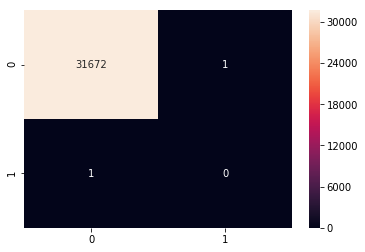

In [184]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [185]:
pd.crosstab(df_test["TIPO_EXPED"], [y_test, y_test_pred_prob > 0.5])

EXISTE_FRAUDE  False       True 
col_1          False True  False
TIPO_EXPED                      
0                158     0     0
1               2538     0     0
2              16053     0     0
3              12491     0     1
4                432     1     0

## Tronador in test

In [186]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.000, 0.500


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


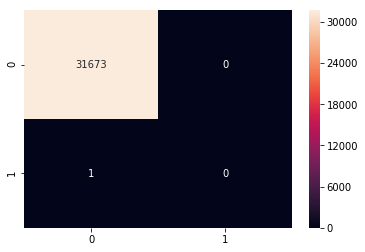

In [187]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [188]:
pd.crosstab(df_test["total_condicion"],df_test["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,26264,1
1.0,4307,0
2.0,334,0
3.0,768,0
